In [1]:
import utils
import quantus
import torch
%matplotlib inline

In [2]:
import cv2
import numpy as np

def resize_image(image_path, target_size=(224, 224)):

    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Image not found: {image_path}")
    img_rgb = img[..., ::-1]
    img_resized = cv2.resize(img_rgb, target_size)
    img_normalized = img_resized / 255.0
    if img_normalized.shape[2] != 3:
        raise ValueError("Image does not have 3 channels")
    return img_normalized
 
 

In [3]:
import torchvision

model = torchvision.models.vgg16(pretrained=True); 
model.eval()
print("Done")

c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\lenovo\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Done


In [4]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import os
from PIL import Image


def heatmap(R):

    b = 10*((np.abs(R)**3.0).mean()**(1.0/3))
    my_cmap = plt.cm.seismic(np.arange(plt.cm.seismic.N))
    my_cmap[:,0:3] *= 0.85
    my_cmap = ListedColormap(my_cmap)
    return my_cmap,b

path_to_files = "imagenet_dataset"

# Load test data and make loaders.
x_batch = torch.load(f'{path_to_files}/x_batch.pt')
y_batch = torch.load(f'{path_to_files}/y_batch.pt')
s_batch = torch.load(f'{path_to_files}/s_batch.pt')
s_batch = s_batch.unsqueeze(dim=1)

In [60]:
import torch
import numpy as np

def LRP(model, input, target):
    mean = torch.Tensor([0.485, 0.456, 0.406]).reshape(1, -1, 1, 1)
    std = torch.Tensor([0.229, 0.224, 0.225]).reshape(1, -1, 1, 1)
    
    # Normalize the batch
    X = (input - mean) / std

    epsilon = 0.25
    gamma = 0.25
    
    delta = 1e-10
    layers = list(model._modules['features']) + utils.toconv(list(model._modules['classifier']))
    L = len(layers)

    batch_size = X.size(0)
    relevance_maps = []

    for i in range(batch_size):
        A = [X[i:i+1]] + [None] * L
        for l in range(L):
            A[l + 1] = layers[l].forward(A[l])
        target_class = target[i]
        T = torch.zeros_like(A[-1])
        T[0, target_class] = 1.0

        R = [None] * L + [(A[-1] * T).data]

        alpha = 0.25
        beta = 0.25

        for l in range(1, L)[::-1]:
            A[l] = A[l].data.requires_grad_(True)
            if isinstance(layers[l], torch.nn.MaxPool2d):
                layers[l] = torch.nn.AvgPool2d(2)
            if isinstance(layers[l], torch.nn.Conv2d) or isinstance(layers[l], torch.nn.AvgPool2d):
            
        
                rho = lambda p: p  + alpha*p.clamp(min=0) + beta*(-1*p).clamp(min=0)  ;                                        incr = lambda z: z ; apply_eps =False

                z = incr(utils.newlayer(layers[l], rho).forward(A[l]))  
                if apply_eps:
                    s = (R[l + 1] / (z + delta + epsilon)  ).data  
                else:
                    s = (R[l + 1] / (z + delta )  ).data  
                (z * s).sum().backward()
                c = A[l].grad  
                R[l] = (A[l] * c).data  
                
            else:
                R[l] = R[l + 1]
            
        for i, l in enumerate([1]):

            A[0] = (A[0].data).requires_grad_(True)

            lb = (A[0].data*0+(0-mean)/std).requires_grad_(True)
            hb = (A[0].data*0+(1-mean)/std).requires_grad_(True)

            z = layers[0].forward(A[0])                                   # step 1 (a)
            z -= utils.newlayer(layers[0],lambda p: p.clamp(min=0)).forward(lb)    # step 1 (b)
            z -= utils.newlayer(layers[0],lambda p: p.clamp(max=0)).forward(hb)    # step 1 (c)
            s = (R[1]/ (z + delta ) ).data                                                      # step 2
            (z*s).sum().backward(); c,cp,cm = A[0].grad,lb.grad,hb.grad            # step 3
            R[0] = (A[0]*c+lb*cp+hb*cm).data                   
                # Collect the relevance map for the current image
        relevance_maps.append(R[0])
    
    # Stack all relevance maps into a single tensor
    relevance_maps = torch.cat(relevance_maps, dim=0)
    
    return relevance_maps



In [61]:
import cv2
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus


grad_cam = GradCAM(model=model, target_layers=[model.features[-1]])
grad_cam_pp = GradCAMPlusPlus(model=model, target_layers=[model.features[-1]])


x = x_batch[:2]
y = y_batch[:2]

grayscale_grad_cam = grad_cam(input_tensor=x )
grayscale_grad_cam_pp = grad_cam_pp(input_tensor=x )
attributions_lrp = LRP(model, input = x ,target=y )



attributions_lrp_np = attributions_lrp.cpu().detach().numpy()
attributions_lrp_np = np.transpose(attributions_lrp_np, (0,2,3,1))
attributions_lrp_np = np.average(attributions_lrp_np, axis=3)
attributions_lrp_np = (attributions_lrp_np.T/np.max(attributions_lrp_np, axis=(1,2)).T).T


# Threshold GradCAM results
grayscale_grad_cam_thr = np.copy(grayscale_grad_cam)
grayscale_grad_cam_thr = grayscale_grad_cam_thr - 0.2
grayscale_grad_cam_thr = np.clip(grayscale_grad_cam_thr, 0, 1)
product_grad_cam = attributions_lrp_np * grayscale_grad_cam_thr
product_grad_cam = (product_grad_cam.T / np.max(product_grad_cam, axis=(1, 2)).T).T


# Threshold GradCAMPP results
grayscale_grad_cam_pp_thr = np.copy(grayscale_grad_cam_pp)
grayscale_grad_cam_pp_thr = grayscale_grad_cam_pp_thr - 0.2
grayscale_grad_cam_pp_thr = np.clip(grayscale_grad_cam_pp_thr, 0, 1)
product_grad_cam_pp = attributions_lrp_np * grayscale_grad_cam_pp_thr
product_grad_cam_pp = (product_grad_cam_pp.T / np.max(product_grad_cam_pp, axis=(1, 2)).T).T

# Smooth the GradCAM result
smoothed_grad_cam = np.zeros(product_grad_cam.shape)
for i in range(0, product_grad_cam.shape[0]):
    smoothed_grad_cam[i] = cv2.GaussianBlur(product_grad_cam[i], (5, 5), cv2.BORDER_DEFAULT)
    smoothed_grad_cam[i] = smoothed_grad_cam[i] / np.max(smoothed_grad_cam[i])

# Smooth the GradCAM result
smoothed_grad_cam_pp = np.zeros(product_grad_cam_pp.shape)
for i in range(0, product_grad_cam_pp.shape[0]):
    smoothed_grad_cam_pp[i] = cv2.GaussianBlur(product_grad_cam_pp[i], (5, 5), cv2.BORDER_DEFAULT)
    smoothed_grad_cam_pp[i] = smoothed_grad_cam_pp[i] / np.max(smoothed_grad_cam_pp[i])

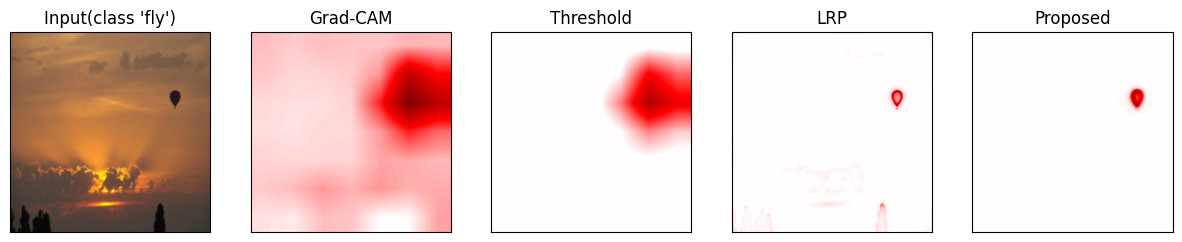

In [62]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 4.5))
idx = 0
axes[0].imshow(np.moveaxis(quantus.normalise_func.denormalise(x_batch[idx].cpu().detach().numpy(), mean=np.array([0.485, 0.456, 0.406]), std=np.array([0.229, 0.224, 0.225])), 0, -1), vmin=0.0, vmax=1.0)
axes[0].title.set_text("Input(class 'fly')")
axes[1].imshow(grayscale_grad_cam[idx], cmap="seismic", vmin=-1.0, vmax=1.0)
axes[1].title.set_text("Grad-CAM")
axes[2].imshow(grayscale_grad_cam_thr[idx], cmap="seismic", vmin=-1.0, vmax=1.0)
axes[2].title.set_text("Threshold")
axes[3].imshow(attributions_lrp_np[idx], cmap="seismic", vmin=-1.0, vmax=1.0)
axes[3].title.set_text("LRP")
axes[4].imshow(smoothed_grad_cam[idx], cmap="seismic", vmin=-1.0, vmax=1.0)
axes[4].title.set_text("Proposed")
for i in range(0, 5):
    axes[i].axis("on")
    axes[i].get_xaxis().set_ticks([])
    axes[i].get_yaxis().set_ticks([])
plt.show()

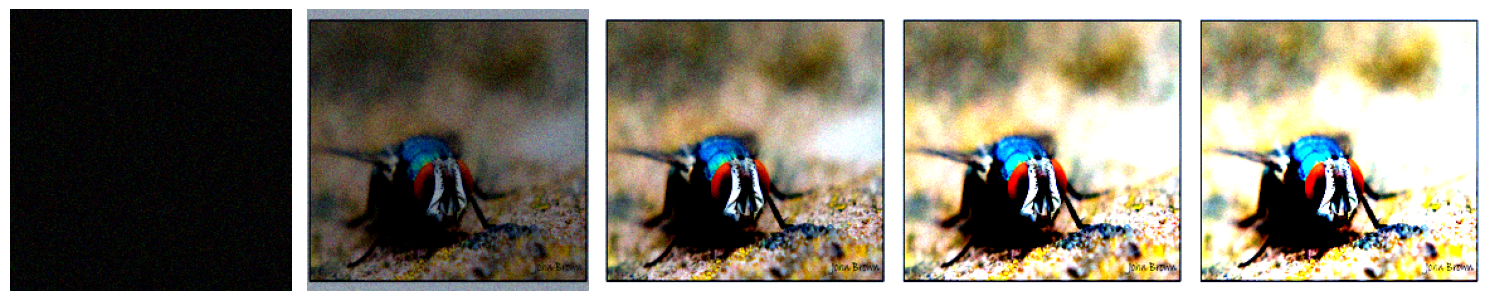

In [110]:
import torch
import matplotlib.pyplot as plt

# Batch of 2 images
x = x_batch[1:2]  # torch.Size([2, 3, 224, 224])

# Define a black image of the same size
black_image = torch.zeros_like(x[0])

# Number of steps for interpolation
num_steps = 5
noise_level = 0.05  # Control how much noise is added

# Interpolation function with noise
def interpolate_images_with_noise(start_img, end_img, num_steps, noise_level):
    interpolated_images = []
    for i in range(num_steps):
        alpha = i / (num_steps - 1)
        # Linear interpolation
        interp_img = (1 - alpha) * start_img + alpha * end_img
        
        # Add random noise
        noise = torch.randn_like(interp_img) * noise_level
        interp_img_with_noise = interp_img + noise
        interp_img_with_noise = torch.clamp(interp_img_with_noise, 0, 1)  # Ensure valid pixel range
        interpolated_images.append(interp_img_with_noise)
    return interpolated_images

# Plot each interpolation for the first image in the batch
interpolated_images = interpolate_images_with_noise(black_image, x[0], num_steps, noise_level)

# Plotting each intermediate image
fig, axes = plt.subplots(1, num_steps, figsize=(15, 5))
for i, img in enumerate(interpolated_images):
    img = img.permute(1, 2, 0).cpu().numpy()  # Change to HWC format for plotting, move to CPU
    axes[i].imshow(img)
    axes[i].axis('off')

plt.tight_layout()
plt.show()


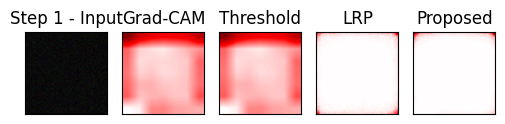

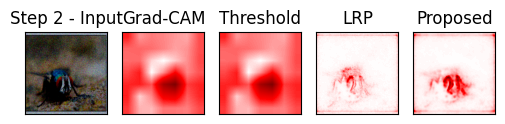

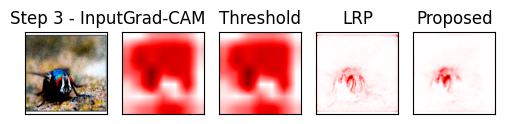

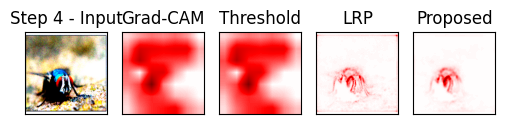

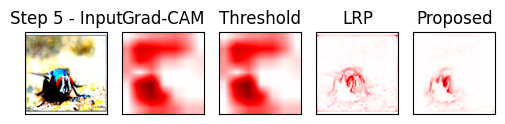

In [112]:


def interpolate_images_with_noise(start_img, end_img, num_steps, noise_level):
    interpolated_images = []
    for i in range(num_steps):
        alpha = i / (num_steps - 1)
        interp_img = (1 - alpha) * start_img + alpha * end_img
        noise = torch.randn_like(interp_img) * noise_level
        interp_img_with_noise = interp_img + noise
        interp_img_with_noise = torch.clamp(interp_img_with_noise, 0, 1)
        interpolated_images.append(interp_img_with_noise)
    return interpolated_images

num_steps = 5
noise_level = 0.1
black_image = torch.zeros_like(x[0])

interpolated_images = interpolate_images_with_noise(black_image, x[0], num_steps, noise_level)
results = []
for step_idx, interp_image in enumerate(interpolated_images):
    interp_image = interp_image.unsqueeze(0)  # Add batch dimension
    
    grayscale_grad_cam = grad_cam(input_tensor=interp_image)
    grayscale_grad_cam_pp = grad_cam_pp(input_tensor=interp_image)
    
    attributions_lrp = LRP(model, input=interp_image, target=y[:1])
    attributions_lrp_np = attributions_lrp.cpu().detach().numpy()
    attributions_lrp_np = np.transpose(attributions_lrp_np, (0, 2, 3, 1))
    attributions_lrp_np = np.average(attributions_lrp_np, axis=3)
    attributions_lrp_np = (attributions_lrp_np.T / np.max(attributions_lrp_np, axis=(1, 2)).T).T
    
    grayscale_grad_cam_thr = np.copy(grayscale_grad_cam)
    grayscale_grad_cam_thr = np.clip(grayscale_grad_cam_thr, 0, 1)
    product_grad_cam = attributions_lrp_np * grayscale_grad_cam_thr
    product_grad_cam = (product_grad_cam.T / np.max(product_grad_cam, axis=(1, 2)).T).T
    
    grayscale_grad_cam_pp_thr = np.copy(grayscale_grad_cam_pp)
    grayscale_grad_cam_pp_thr = np.clip(grayscale_grad_cam_pp_thr, 0, 1)
    product_grad_cam_pp = attributions_lrp_np * grayscale_grad_cam_pp_thr
    product_grad_cam_pp = (product_grad_cam_pp.T / np.max(product_grad_cam_pp, axis=(1, 2)).T).T
    
    smoothed_grad_cam = np.zeros(product_grad_cam.shape)
    for i in range(product_grad_cam.shape[0]):
        smoothed_grad_cam[i] = cv2.GaussianBlur(product_grad_cam[i], (5, 5), cv2.BORDER_DEFAULT)
        smoothed_grad_cam[i] = smoothed_grad_cam[i] / np.max(smoothed_grad_cam[i])
    
    smoothed_grad_cam_pp = np.zeros(product_grad_cam_pp.shape)
    for i in range(product_grad_cam_pp.shape[0]):
        smoothed_grad_cam_pp[i] = cv2.GaussianBlur(product_grad_cam_pp[i], (5, 5), cv2.BORDER_DEFAULT)
        smoothed_grad_cam_pp[i] = smoothed_grad_cam_pp[i] / np.max(smoothed_grad_cam_pp[i])
    
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(5, 1.5))
    idx = 0  
    axes[0].imshow(interp_image[idx].permute(1, 2, 0).cpu().detach().numpy(), vmin=0.0, vmax=1.0)

    axes[0].title.set_text(f"Step {step_idx+1} - Input")
    axes[1].imshow(grayscale_grad_cam[idx], cmap="seismic", vmin=-1.0, vmax=1.0)
    axes[1].title.set_text("Grad-CAM")
    axes[2].imshow(grayscale_grad_cam_thr[idx], cmap="seismic", vmin=-1.0, vmax=1.0)
    axes[2].title.set_text("Threshold")
    axes[3].imshow(attributions_lrp_np[idx], cmap="seismic", vmin=-1.0, vmax=1.0)
    axes[3].title.set_text("LRP")
    axes[4].imshow(smoothed_grad_cam[idx], cmap="seismic", vmin=-1.0, vmax=1.0)
    results.append(smoothed_grad_cam[idx])
    axes[4].title.set_text("Proposed")
    
    for i in range(5):
        axes[i].axis("on")
        axes[i].get_xaxis().set_ticks([])
        axes[i].get_yaxis().set_ticks([])
    
    plt.tight_layout()
    plt.show()

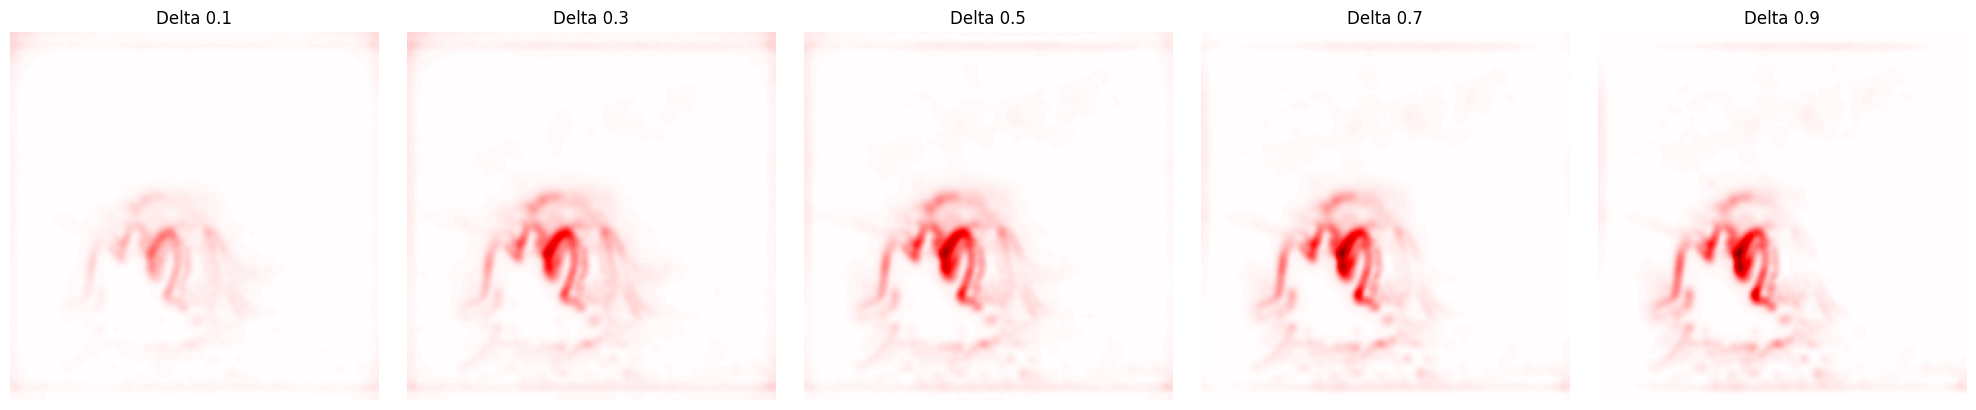

In [113]:
import matplotlib.pyplot as plt
import numpy as np

def plot_images_per_delta_with_interpolation(results, deltas):
    num_deltas = len(deltas)  
    num_images = len(results)
    fig, axs = plt.subplots(1, num_deltas, figsize=(num_deltas * 4, 4))
    for col_idx, delta in enumerate(deltas):
        final = np.zeros_like(results[0]) 
        for i in range(num_images):
            final = final * (1 - delta) + results[i] * delta
        axs[col_idx].imshow(final, cmap="seismic", vmin=-1.0, vmax=1.0)
        axs[col_idx].axis('off')  
        axs[col_idx].set_title(f"Delta {delta}", fontsize=12)
    plt.tight_layout()
    plt.show()
deltas = [0.1, 0.3, 0.5, 0.7, 0.9] 
plot_images_per_delta_with_interpolation(results, deltas)
